In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl    
mpl.rc('font',family='serif')

import seaborn as sns

import xgboost as xgb 
# from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.utils.fixes import signature
from imblearn.under_sampling import RandomUnderSampler  

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda

In [2]:
pkl_file = open('new_test_df.pkl', 'rb')

df_test = pickle.load(pkl_file)

pkl_file.close()

pkl_file = open('new_train_df.pkl', 'rb')

df_train = pickle.load(pkl_file)

pkl_file.close()



In [3]:
def get_Xy(test_year):
    X_labels = ['dce_mu','cm_mu','dce_slope','cm_slope','dce_acc','cm_acc','cm_mass','dce_mass']
    y_label = ['binary_best'] # Sloppy binarization

    df_test['binary_best'] = (df_test['best']>0)+0
    df_train['binary_best']  = (df_train['best']>0)+0
    
    
    X_train = df_train[X_labels]
    y_train = np.array(df_train[y_label]).ravel()

# one year
    year = test_year
    X_test = df_test[df_test['year']==year][X_labels]
    y_test = np.array(df_test[df_test['year']==year][y_label]).ravel()
    
    return(X_train, y_train, X_test, y_test)

In [4]:
def make_dict():
    dict_of_metrics = {}
    dict_of_metrics['auc'] = []
    dict_of_metrics['ap'] = []
    dict_of_metrics['recall'] = []
    dict_of_metrics['precision'] = []
    dict_of_metrics['preds1'] = []
    dict_of_metrics['preds0'] = []
    dict_of_metrics['preds_bayes'] = []
    dict_of_metrics['feature_imp'] = []
    
    return(dict_of_metrics)

In [5]:
def run_models(iterations, X_train, y_train, X_test, y_test, dict_of_metrics):

    random_seeds = np.random.randint(1000,9999,iterations)

    for i, j in enumerate(random_seeds):
        rus = RandomUnderSampler(random_state=j)
        X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=j)
        xg_cl.fit(X_train_rus, y_train_rus)

        preds = xg_cl.predict_proba(np.array(X_test))
        
#         dict_of_metrics['preds1'].append(preds_bayes) # nice to have both columns for the baysian correction
#         dict_of_metrics['preds0'].append(preds_bayes) # nice to have both columns for the baysian correction
    
        
        # for baysian correction
        ones = df_train['binary_best'].sum()/df_train['binary_best'].shape[0]
        zeroes = 1 - (df_train['binary_best'].sum()/df_train['binary_best'].shape[0])
        
        # baysian corrected probs - the right one to use for maps and stuff.
        preds_bayes = (np.array(preds[:,1])*ones)/((np.array(preds[:,1])*ones)+(np.array(preds[:,0])*zeroes))
        dict_of_metrics['preds_bayes'].append(preds_bayes)
        
        
        # Save results:
        dict_of_metrics['auc'].append(roc_auc_score(np.array(y_test),preds_bayes))
        dict_of_metrics['ap'].append(average_precision_score(np.array(y_test),preds_bayes))

        precision, recall, _ = precision_recall_curve(np.array(y_test),preds_bayes)

        dict_of_metrics['recall'].append(recall)
        dict_of_metrics['precision'].append(precision) 

        dict_of_metrics['preds1'].append(preds[:,1]) # Not imp. after baysian correction, but nice to have
        dict_of_metrics['preds0'].append(preds[:,0]) # Not imp. after baysian correction, but nice to have

#         dict_of_metrics['preds1'].append(preds_bayes) # nice to have both columns for the baysian correction
#         dict_of_metrics['preds0'].append(preds_bayes) # nice to have both columns for the baysian correction
        
#         # for baysian correction
#         ones = df_train['binary_best'].sum()/df_train['binary_best'].shape[0]
#         zeroes = 1 - (df_train['binary_best'].sum()/df_train['binary_best'].shape[0])
        
#         # baysian corrected probs - the right one to use for maps and stuff.
#         dict_of_metrics['preds_bayes'] = (np.array(dict_of_metrics['preds1'])*ones)/((np.array(dict_of_metrics['preds1'])*ones)+(np.array(dict_of_metrics['preds0'])*zeroes))
        
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)
        
        #dict_of_metrics['prc'].append(precision_recall_curve(np.array(y_test),preds[:,1]))

        print('{}/{}'.format(i+1,len(random_seeds)), end = ' - ')
        
    # for the mean     
    mean_preds = np.array(dict_of_metrics['preds_bayes']).mean(0)
    precision_mean, recall_mean, _ = precision_recall_curve(y_test,mean_preds)
    
    dict_of_metrics['mean_ap'] = np.mean(dict_of_metrics['ap'])
    dict_of_metrics['high_ap'] = np.percentile(np.array(dict_of_metrics['ap']),99.5)
    dict_of_metrics['low_ap'] = np.percentile(np.array(dict_of_metrics['ap']),00.5) 
    
    dict_of_metrics['recall_mean'] = recall_mean
    dict_of_metrics['precision_mean'] = precision_mean
    dict_of_metrics['mean_preds'] = mean_preds
        
    print('done')
    
    return(iterations, dict_of_metrics)

In [6]:
def model_loop(iters, start_year, end_year):
    print('Stating loop. First included year {}. Last included year {}. {} iterations over each year\n'.format(start_year,end_year,iters))
    time0 = time.time()
    dict_of_dicts = {}

    for i in np.arange(start_year,end_year+1,1):
        print('\nprocessing {}'.format(i))
        X_train, y_train, X_test, y_test = get_Xy(i)
        dict_of_metrics = make_dict()
        iterations, dict_of_metrics = run_models(iters, X_train, y_train, X_test, y_test, dict_of_metrics)

        dict_of_dicts[str(i)] = dict_of_metrics
        
        
    time1 = time.time()
    time1 = time.time()
    k1 = (time1 - time0)/60
    print('\ntime total: {:.3}min'.format(k1))
    print('\nALL DONE!')
    return(dict_of_dicts, iterations)

In [7]:
dict_of_dicts, iterations = model_loop(1000,2013,2017)

Stating loop. First included year 2013. Last included year 2017. 1000 iterations over each year


processing 2013
1/1000 - 2/1000 - 3/1000 - 4/1000 - 5/1000 - 6/1000 - 7/1000 - 8/1000 - 9/1000 - 10/1000 - 11/1000 - 12/1000 - 13/1000 - 14/1000 - 15/1000 - 16/1000 - 17/1000 - 18/1000 - 19/1000 - 20/1000 - 21/1000 - 22/1000 - 23/1000 - 24/1000 - 25/1000 - 26/1000 - 27/1000 - 28/1000 - 29/1000 - 30/1000 - 31/1000 - 32/1000 - 33/1000 - 34/1000 - 35/1000 - 36/1000 - 37/1000 - 38/1000 - 39/1000 - 40/1000 - 41/1000 - 42/1000 - 43/1000 - 44/1000 - 45/1000 - 46/1000 - 47/1000 - 48/1000 - 49/1000 - 50/1000 - 51/1000 - 52/1000 - 53/1000 - 54/1000 - 55/1000 - 56/1000 - 57/1000 - 58/1000 - 59/1000 - 60/1000 - 61/1000 - 62/1000 - 63/1000 - 64/1000 - 65/1000 - 66/1000 - 67/1000 - 68/1000 - 69/1000 - 70/1000 - 71/1000 - 72/1000 - 73/1000 - 74/1000 - 75/1000 - 76/1000 - 77/1000 - 78/1000 - 79/1000 - 80/1000 - 81/1000 - 82/1000 - 83/1000 - 84/1000 - 85/1000 - 86/1000 - 87/1000 - 88/1000 - 89/1000 - 90/10

# Pickle the dict_of_dicts

In [8]:
file_name = "xgboost_dict_of_dicts.pkl"
output = open(file_name, 'wb') 
pickle.dump(dict_of_dicts, output)
output.close()

# Test pickle:

In [9]:
pkl_file = open('xgboost_dict_of_dicts.pkl', 'rb')
dict_of_dicts = pickle.load(pkl_file)
pkl_file.close()

# PLOTS and Results; shoud be move to other note book

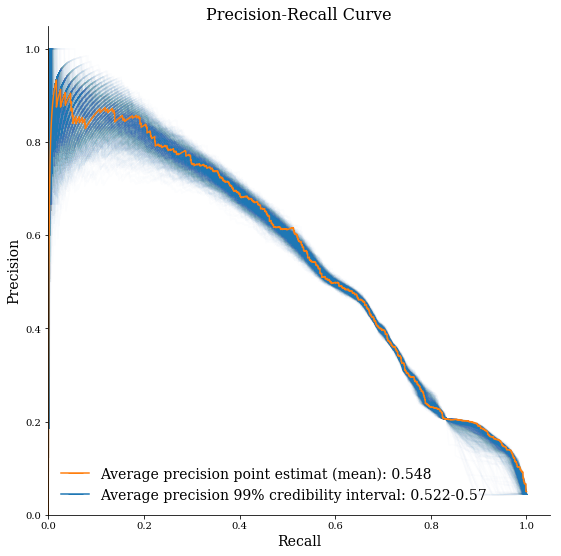

In [10]:
dict_of_metrics = dict_of_dicts['2013']

plt.figure(figsize=[9,9])

for i in np.arange(0,iterations,1):
    plt.plot(dict_of_metrics['recall'][i], dict_of_metrics['precision'][i], color='C0', alpha=0.01)
    
mean_ap = dict_of_metrics['mean_ap']
high_ap = dict_of_metrics['high_ap']
low_ap = dict_of_metrics['low_ap']
    
plt.plot(dict_of_metrics['recall_mean'], dict_of_metrics['precision_mean'], color='C1', alpha=1)

plt.title('Precision-Recall Curve', fontsize = 16)
    
plt.xlabel('Recall', fontsize = 14)
plt.ylabel('Precision', fontsize = 14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

sns.despine()

cred_label = "Average precision 99% credibility interval: " + str(low_ap.round(3)) + '-' + str(high_ap.round(2))
mean_label = 'Average precision point estimat (mean): ' + str(mean_ap.round(3))


cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

plt.legend(handles=[mean_line, cred_line],frameon = False, fontsize = 14)

plt.show()


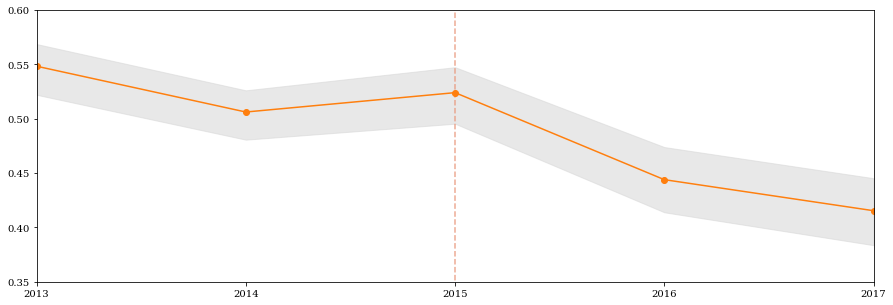

In [11]:
ap_means = []
ap_highs = []
ap_lows = []
years = []

for i in np.arange(2013,2018,1):
    ap_means.append(dict_of_dicts[str(i)]['mean_ap'])
    ap_highs.append(dict_of_dicts[str(i)]['high_ap'])
    ap_lows.append(dict_of_dicts[str(i)]['low_ap'])

    years.append(i)

    
plt.figure(figsize=[15,5])
    
plt.plot(years,ap_means, '-o', color = 'C1')
#plt.plot(years,ap_highs, color = 'gray')
#plt.plot(years,ap_lows, color = 'gray')

plt.fill_between(years, ap_highs, ap_lows, color = 'lightgray', alpha = 0.5)

plt.vlines(2012+3,0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

plt.xticks(years)

plt.xlim(2013,2017)
plt.ylim(0.35,0.6)

plt.show()

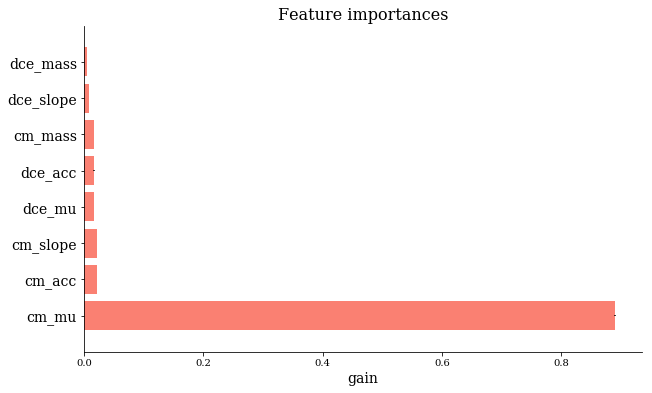

In [12]:
importances = np.array(dict_of_metrics['feature_imp']).mean(0)
importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


indices = np.argsort(importances)[::-1]

size = len(importances)

plt.figure(figsize=[10,int(size)*0.75])

plt.title("Feature importances", fontsize = 16)


plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

X_labels = ['dce_mu','cm_mu','dce_slope','cm_slope','dce_acc','cm_acc','cm_mass','dce_mass']

plt.yticks(range(size),  np.array(X_labels)[indices], fontsize = 14)
plt.ylim([-1, size])

plt.xlabel('gain', fontsize = 14)
    #plt.ylabel('features', fontsize = 14)

sns.despine()
    
#plt.savefig(fig_title, bbox_inches="tight")
    
plt.show()

# Maps - du bruger 2014 som exemple!

### probmap

In [13]:
def prob_map(year):
    df_test_sub_ = df_test[df_test['year']==year].copy()
    df_test_sub_['predsB'] = dict_of_dicts[str(year)]['mean_preds']
    df_test_sub_.plot(column = 'predsB', figsize=[15,15])
    
    # need predefined min, max and colorbar!
    
    plt.show()

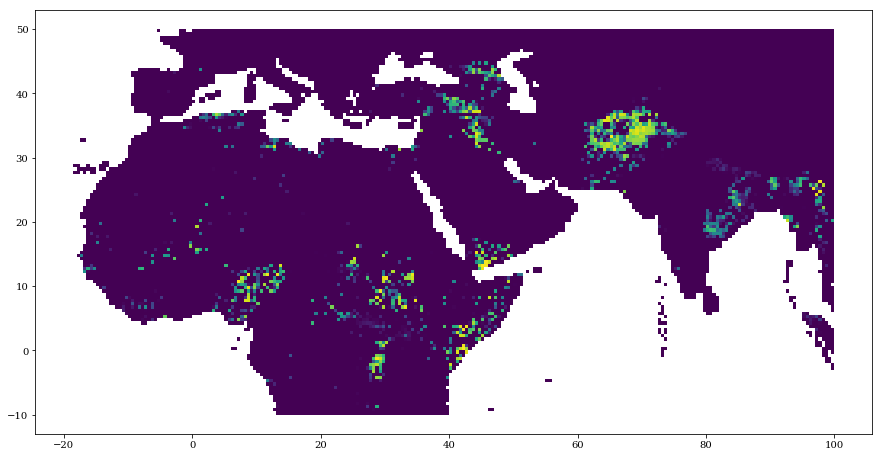

In [14]:
prob_map(2014)

# distributions

In [15]:
# df_test_2015 = df_test[df_test['year']==2015].copy()
# df_test_2015['predsB'] = dict_of_dicts['2015']['mean_preds']


# plt.hist(df_train[df_train['year']==2012]['binary_best'])
# plt.show()

# print(df_train[df_train['year']==2012]['binary_best'].sum()/df_train[df_train['year']==2012]['binary_best'].shape[0])

# # 2014
# binary_pred = (df_test_2014['predsB']>0.15)*1
# df_test_2014['binary_pred'] =  binary_pred

# plt.hist(df_test_2014['binary_pred'])
# plt.show()

# print(df_test_2014['binary_pred'].sum()/df_test_2014['binary_pred'].shape[0])

# # 2015
# binary_pred = (df_test_2015['predsB']>0.15)*1
# df_test_2015['binary_pred'] =  binary_pred

# plt.hist(df_test_2015['binary_pred'])
# plt.show()

# print(df_test_2015['binary_pred'].sum()/df_test_2015['binary_pred'].shape[0])



### Confusion maps:

In [16]:
# from sklearn.metrics import confusion_matrix

# binary_pred = (df_test_2014['predsB']>0.15)*1 # 0.35 to match posterior of 2014 distrbution with actually output
# df_test_2014['binary_pred'] =  binary_pred

# tn, fp, fn, tp = confusion_matrix(df_test_2014['binary_best'], df_test_2014['binary_pred']).ravel()
# (tn, fp, fn, tp)

In [17]:
def confusion_map(year, threshold):
    sub_df_test = df_test[df_test['year']==year].copy()
    sub_df_test['predsB'] = dict_of_dicts[str(year)]['mean_preds']

    binary_pred = (sub_df_test['predsB']>threshold)*1 # should be 0.15 to match posterior of 2012 (last observed year) distrbution with actually output
    sub_df_test['binary_pred'] =  binary_pred
    
    sub_df_test['TP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 1))*1
    sub_df_test['TN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 1))*1

    cats_list = ['TN','TP','FP','FN']

    plt.figure(figsize=[13.8,7])

    colors = ['lightgrey','salmon','teal','crimson']
    labels = ['true negatives', 'true positives', 'false positives', 'false negatives']

    for i, j in enumerate(cats_list):
        X = np.array([sub_df_test[sub_df_test[j]==1]['xcoord'], sub_df_test[sub_df_test[j]==1]['ycoord']]).T

        plt.scatter(X[:,0], X[:,1], s=6, c = colors[i], marker='s', label = labels[i])

    plt.title('Predictions {}\n Last year included i model: 2012\nThreshold: {}% probability of conflict'.format(year,threshold * 100))
    plt.legend()

    fig_title = 'confusion_map_{}.pdf'.format(year)
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

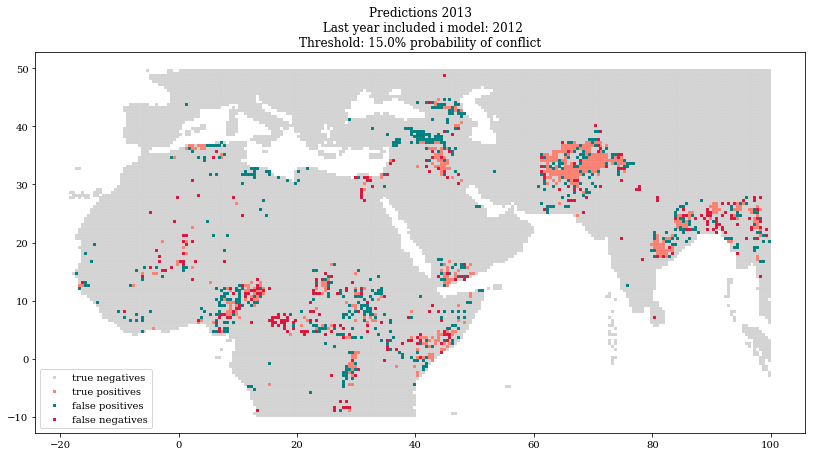

In [18]:
confusion_map(2013,0.15)

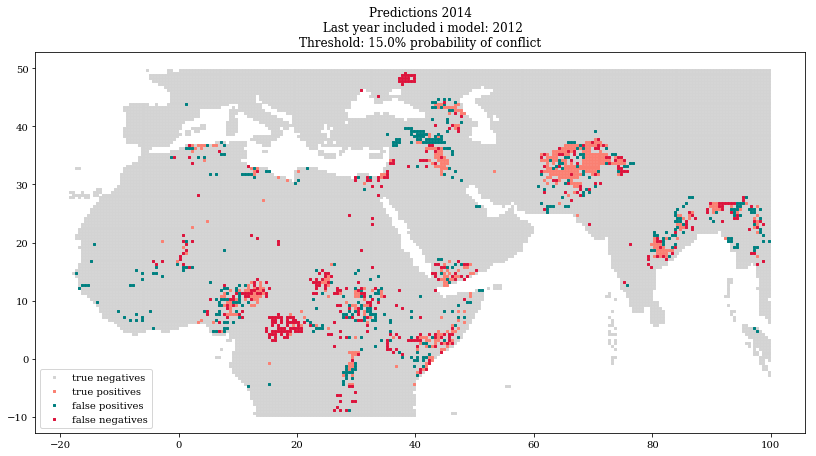

In [19]:
confusion_map(2014,0.15)

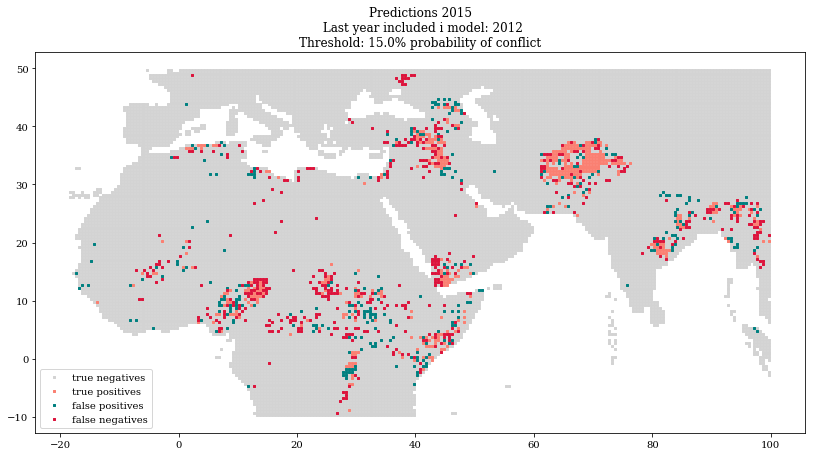

In [20]:
confusion_map(2015,0.15)